# Data generating module
Generate the synthetic data and then save using pickle (useful for importing to the other environment due to potential library conflicts).

In [8]:
import gpflux
import gpflow
import numpy as np
import tensorflow as tf
from gpflux.helpers import construct_basic_kernel, construct_basic_inducing_variables
from gpflux.layers import GPLayer
from gpflux.experiment_support.plotting import plot_layer
import pickle
from matplotlib import pyplot as plt
import ruptures as rpt
from scipy.stats import wasserstein_distance
from scipy.optimize import brentq

2026-02-16 14:29:49.759046: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-16 14:29:51.351019: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2026-02-16 14:29:51.918180: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2026-02-16 14:29:51.922450: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-02-16 14:29:52.947148: I tensorflow/core/platform/cpu_feature_gua

## Poisson Point Process

We start by defining an intensity function for the Non-Homogeneous Poisson process (NHPP) and then generate a Point process using a thinning algorithm that can be found here (https://www.columbia.edu/~ks20/4703-Sigman/4703-07-Notes-PP-NSPP.pdf)

In [2]:
def lam(x, a):
    """
    Intensity function for the NHPP
    """
    return a + np.sin(x)

In [3]:
def sample_poisson_jumps(a=10, lambda_star=11, length=1000, seed=None, segment_length=256):
    """
    Thinning algorithm for generating a poisson point process signal
    that alternates monotonicity every segment_length points.
    """
    if seed is not None:
        np.random.seed(seed)
    T = 0.01 * length
    t = 0.0
    n = 0
    arrival_times = []
    while True:
        u = np.random.rand()
        t = t - (1/lambda_star) * np.log(u)
        if t > T:
            break
        u = np.random.rand()
        lambda_t = lam(t, a)
        if u <= lambda_t / lambda_star:
            n += 2
            arrival_times.append(t)
    ts = np.linspace(0, T, length)
    ys = np.searchsorted(arrival_times, ts)
    

    increments = np.diff(ys, prepend=ys[0])
    
    segment_indices = np.arange(length) // segment_length
    signs = np.where(segment_indices % 2 == 0, 1, -1)
    ys_alternating = np.cumsum(increments * signs)
    
    return ts, ys_alternating, arrival_times, T

In [4]:
def sample_multiple_poisson(a, lambda_star, length, num_samples, seed=None):
    "Sample many Poisson base signals"
    signals = []
    tau = None
    tss = None
    for i in range(num_samples):
        current_seed = seed + i if seed is not None else None
        ts, ys, arrival_times, T = sample_poisson_jumps(a, lambda_star, length, current_seed)
        signals.append(ys)
        tau = T
        tss = ts
    return np.stack(signals, axis=0), tau, tss

## Deep Gaussian Process (DGP)

We continue with defining the hierarchical structure of the signals. We start by defining a helper function for sampling layer kernels and hyperparameters. The DGP model is constructed by first sampling from two stationary kernels supported by GPFlow for each layer while fixing the lengthscales and variance hyperparameters to 0.5 and 1.0 respectively. We then create a set of datapoints that are propagated through a number of predefined layers and save the output of the final layer.

In [5]:
# The kernels we will be using for the layers
KERNELS = [gpflow.kernels.SquaredExponential,
          gpflow.kernels.Matern12]

In [6]:
def randomly_sample_kernels(kernels, num_kernels, seed=None):
    """Helper function for sampling a corresponding kernel for each DGP layer."""
    if seed is not None:
        np.random.seed(seed)
    sampled_kernels = []
    for i in range(num_kernels):
        kernel = np.random.choice(kernels)()
        lengthscales = np.random.uniform(0.5, 0.5)
        variance = np.random.uniform(1.0, 1.0)
        kernel.lengthscales.assign(lengthscales)
        kernel.variance.assign(variance)
        sampled_kernels.append(kernel)
    return sampled_kernels

In [8]:
def sample_dgp_signal(segment_length, a, b, num_samples, kernels, num_layers, seed=None, reverse=False):
    """
    Sample num_samples trajectories where each segment of segment_length 
    corresponds to a DGP layer output.
    """
    if seed is not None:
        np.random.seed(seed)
        tf.random.set_seed(seed)
    
    X = np.linspace(a, b, segment_length).reshape(-1, 1)
    Z = X.copy()
    M = Z.shape[0]
    D = 1
    
    gp_layers = []
    for i in range(num_layers):
        ind_var = construct_basic_inducing_variables(M, D, D, share_variables=True, z_init=Z.copy())
        kernel = construct_basic_kernel(kernels[i], output_dim=D, share_hyperparams=True)
        layer_num_samples = num_samples if i == 0 else 1
        gplayer = GPLayer(
            kernel,
            ind_var,
            segment_length,
            full_cov=True,
            num_samples=layer_num_samples,
            mean_function=gpflow.mean_functions.Zero(),
        )
        gp_layers.append(gplayer)
    
    layer_input = X
    all_segments = []
    
    for i, layer in enumerate(gp_layers):
        layer_output = layer(layer_input)
        sample = tf.convert_to_tensor(layer_output)
        
        if i == 0:
            layer_input = sample
        else:
            layer_input = sample[0]
        
        segment = np.squeeze(layer_input.numpy(), axis=-1)
        all_segments.append(segment)
    if reverse:
        all_segments = all_segments[::-1]
    
    final = np.concatenate(all_segments, axis=1)
    
    total_length = segment_length * num_layers
    xs = np.linspace(a, b * num_layers, total_length)
    
    return final, all_segments, xs

In [9]:
def sequences(a, lambda_star, length, kernels, num_layers, num_samples,poisson_seed=None, kernel_seed=None, dgp_seed=None):
    segment_length = length // num_layers
    baselines, T, xs = sample_multiple_poisson(a, lambda_star, length, num_samples, poisson_seed)
    final, all_segments, xs = sample_dgp_signal(segment_length, 0, T, num_samples, kernels, num_layers, dgp_seed, reverse=True)
    seqs = baselines + final
    return T, baselines, seqs, all_segments

## We can now generate the time series we will need to train and evaluate our models on

We sample one synthetic dataset of num_samples = 1024 and seq_len = 1024. We produce the flat structure as described in the thesis.

In [10]:
dataset = {}

In [11]:
seed = 500
kernels = randomly_sample_kernels(KERNELS, 4, seed)
T, baselines, samples, segments = sequences(4, 5, 1024, kernels, 4, 1024, seed, seed, seed)


2026-01-27 22:48:52.674396: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [12]:
dataset["dgp_dataset"] = {"T": T, "baselines": baselines, "samples":samples, "segments":segments}

## We can now save the dataset in order to import it to another environment

In [13]:
from pathlib import Path

save_path = "data/synthetic_datasets_segments.pkl"
with open(save_path, "wb") as f:
    pickle.dump(dataset, f)
print(f"Saved to {save_path}")

Saved to data/synthetic_datasets_segments.pkl


# Estimation

After training and prediction, we are able to extract meaningful statistics out of the generated sequences which we can then use to quantitatively compare the outputs with the ground truth. First, we start with mapping each signal to a triple contatining changepoint count, jump mean differences and segment variances.

In [1]:
def estimate_cp(signal, pen=10):
    """Helper function which returns a ruptures model using the Pelt algorithm, an L2 segment cost function with a penalty (default 10)."""
    return rpt.Pelt(model='l2').fit(signal).predict(pen=pen)

In [2]:
def extract_signal_statistics(ys):
    # First, estimate the changepoints
    cps = estimate_cp(ys)
    cps = np.asarray(cps, dtype=int)
    
    # Get the boundaries of each changepoint
    boundaries = np.concatenate(([0], cps))
    inter_arrivals = np.diff(boundaries)
    num_cps = len(cps)

    means = []
    variances = []
    lengths = inter_arrivals
    segments = [(boundaries[i],boundaries[i+1]) for i in range(len(boundaries)-1)]
    for (start, end) in segments:
        segment = ys[start:end]
        means.append(segment.mean())
        variances.append(segment.var())
    # Local statistics, means, variances and lengths
    means = np.asarray(means)
    variances = np.asarray(variances)

    # Jumps in means
    jumps = np.diff(means)


    statistics =  {
        "cps" : cps,
        "num_cps" : num_cps,
        "inter_arrivals": inter_arrivals,
        "lengths": lengths,
        "means": means,
        "variances": variances,
        "jumps": jumps,
        }
    return statistics

In addition, it is important to implement a method for estimating the alpha parameter of the intensity function. To do this, we use the score equation as laid out in the thesis and use scipy to find a numerical solution.

In [30]:
def score(a, t_i, k, t):
    return np.sum(1 / (a + np.sin(t_i))) - (k * t)

def estimate_a(stats_list, T, a_min=1.001, a_max=100.0):
    all_cps = []
    K = len(stats_list)
    n_points = int(T / 0.01)
    for stats in stats_list:
        cps = stats["cps"]
        cps = cps[cps < n_points] # This is because ruptures includes the last index as a changepoint always.
        actual_cps = cps * 0.01
        all_cps.extend(actual_cps.tolist())
    t_i = np.array(all_cps, dtype=float)
    if len(t_i) == 0:
        return np.nan
    a_hat = brentq(score, a_min, a_max, args=(t_i, K, T))
    return a_hat

## In-segment evaluation

In [42]:
with open("out/predictions/in_segment.pkl", "rb") as f:
    results = pickle.load(f)
with open("data/synthetic_datasets_segments.pkl", "rb") as f:
    samples = pickle.load(f)
signals = samples["dgp_dataset"]["samples"][819:]

In [43]:
seeds = [3040 + i for i in range(10)]
segments = [1, 2, 3, 4]

First, we evaluate the statistics of the ground truth signals.

In [44]:
gt_stats = {}
for seg_idx in segments:
    seg_start = (seg_idx - 1) * 256
    gt_stats[seg_idx] = []
    for j in range(signals.shape[0]): # go through all 205 signals.
        gt_signal = signals[j, seg_start + 128 : seg_start + 256]
        stats = extract_signal_statistics(gt_signal)
        gt_stats[seg_idx].append(stats)

Then, those of the predicted signals. These correspond to the 2nd half of the number of time points in the sequence.

In [45]:
pred_stats = {}
for seed in seeds:
    pred_stats[seed] = {}
    for seg_idx in segments:
        pred_stats[seed][seg_idx] = []
        for j in range(signals.shape[0]):
            # Get the 2nd half of the signal, that is the predicted section
            pred_signal = results[seed][f"segment{seg_idx}"][j, 128:]
            stats = extract_signal_statistics(pred_signal)
            pred_stats[seed][seg_idx].append(stats)

Now we can define the comparisons.

In [46]:
evaluation = {}
for seed in seeds:
    evaluation[seed] = {}
    for seg_idx in segments:
        # look through all segments with the same segment index
        gt_K = np.array([s["num_cps"] for s in gt_stats[seg_idx]])
        pred_K = np.array([s["num_cps"] for s in pred_stats[seed][seg_idx]])
        mae_K = np.mean(np.abs(gt_K - pred_K)) # 1) MAE
        gt_jumps = np.concatenate([s["jumps"] for s in gt_stats[seg_idx]])
        pred_jumps = np.concatenate([s["jumps"] for s in pred_stats[seed][seg_idx]])
        gt_vars = np.concatenate([s["variances"] for s in gt_stats[seg_idx]])
        pred_vars = np.concatenate([s["variances"] for s in pred_stats[seed][seg_idx]])
        w1_jumps = wasserstein_distance(gt_jumps, pred_jumps) # 2) W1(delta)
        w1_vars = wasserstein_distance(gt_vars, pred_vars) # 3) W1(sigma^2)
        evaluation[seed][seg_idx] = {
            "mae_K": mae_K,
            "w1_jumps": w1_jumps,
            "w1_vars": w1_vars,
        }

We use the metrics as defined in the thesis to get qualitative comparisons between ground truth and generated signals

In [47]:
for seg_idx in segments:
    mae_vals = [evaluation[seed][seg_idx]["mae_K"] for seed in seeds]
    w1j_vals = [evaluation[seed][seg_idx]["w1_jumps"] for seed in seeds]
    w1v_vals = [evaluation[seed][seg_idx]["w1_vars"] for seed in seeds]

    print(f"D={5-seg_idx} MAE:{np.mean(mae_vals):.3f} (+-) {np.std(mae_vals):.3f} | W1(delta): {np.mean(w1j_vals):.3f} (+-) {np.std(w1j_vals):.3f} | W1(sigma): {np.mean(w1v_vals):.3f} (+-) {np.std(w1v_vals):.3f}") 

D=4 MAE:1.564 (+-) 0.153 | W1(delta): 3.151 (+-) 0.138 | W1(sigma): 0.537 (+-) 0.283
D=3 MAE:1.647 (+-) 0.251 | W1(delta): 2.603 (+-) 0.204 | W1(sigma): 0.586 (+-) 0.659
D=2 MAE:1.813 (+-) 0.102 | W1(delta): 2.812 (+-) 0.146 | W1(sigma): 1.278 (+-) 1.045
D=1 MAE:1.826 (+-) 0.134 | W1(delta): 4.890 (+-) 2.267 | W1(sigma): 58.548 (+-) 65.100


Investigate a possible monotonic reversal trend.

In [48]:
for seg_idx in segments:
    gt_jumps = np.concatenate([s["jumps"] for s in gt_stats[seg_idx]])
    raw_w1 = []
    abs_w1 = []
    for seed in seeds:
        pred_jumps = np.concatenate([s["jumps"] for s in pred_stats[seed][seg_idx]])
        raw_w1.append(wasserstein_distance(gt_jumps, pred_jumps))
        abs_w1.append(wasserstein_distance(np.abs(gt_jumps), np.abs(pred_jumps)))
    print(f"D={5-seg_idx}  W1(Δ) {np.mean(raw_w1):.3f} (+-) {np.std(raw_w1):.3f} | W1(|Delta|) {np.mean(abs_w1):.3f} (+-) {np.std(abs_w1):.3f}")

D=4  W1(Δ) 3.151 (+-) 0.138 | W1(|Delta|) 0.206 (+-) 0.087
D=3  W1(Δ) 2.603 (+-) 0.204 | W1(|Delta|) 0.397 (+-) 0.178
D=2  W1(Δ) 2.812 (+-) 0.146 | W1(|Delta|) 0.364 (+-) 0.113
D=1  W1(Δ) 4.890 (+-) 2.267 | W1(|Delta|) 2.734 (+-) 2.355


Further evidence for a monotonic reversal, get the signs of the jumps in mean

In [49]:
for seg_idx in segments:
    gt_jumps = np.concatenate([s["jumps"] for s in gt_stats[seg_idx]])
    all_pred_means = []
    all_pred_stds = []
    for seed in seeds:
        pred_jumps = np.concatenate([s["jumps"] for s in pred_stats[seed][seg_idx]])
        all_pred_means.append(np.mean(pred_jumps))
        all_pred_stds.append(np.std(pred_jumps))
    print(f" D={seg_idx}: ")
    print(f" Ground truth:   mean={np.mean(gt_jumps):.3f}")
    print(f" Pred: mean={np.mean(all_pred_means):.3f}")

 D=1: 
 Ground truth:   mean=1.791
 Pred: mean=-1.341
 D=2: 
 Ground truth:   mean=-1.460
 Pred: mean=1.079
 D=3: 
 Ground truth:   mean=1.673
 Pred: mean=-1.032
 D=4: 
 Ground truth:   mean=-1.425
 Pred: mean=1.001


## Cross-Segment evaluation

In [51]:
with open("out/predictions/cross_segment.pkl", "rb") as f:
    cross_results = pickle.load(f)
with open("data/synthetic_datasets_segments.pkl", "rb") as f:
    samples = pickle.load(f)
signals = samples["dgp_dataset"]["samples"][819:]

In [52]:
seeds = [3040 + i for i in range(10)]
transitions = {
    "segment1": (256, 512),
    "segment2": (512, 768),
    "segment3": (768, 1024),
}# here we have 3 segments, essentially (255,511), (512,767), (768,1023) starting from 0. Indices here are different due to slicing.

In [53]:
gt_stats = {}
for name, (gt_start, gt_end) in transitions.items():
    gt_stats[name] = []
    for j in range(signals.shape[0]):
        gt_signal = signals[j, gt_start:gt_end]
        stats = extract_signal_statistics(gt_signal)
        gt_stats[name].append(stats)

In [54]:
segments = ["segment1", "segment2", "segment3"]
pred_stats = {}
for seed in seeds:
    pred_stats[seed] = {}
    for segment in segments:
        pred_stats[seed][segment] = []
        for j in range(signals.shape[0]):
            pred_signal = cross_results[seed][segment][j, 256:] # All of these are basically signals of length 512 denoted by the segment
            stats = extract_signal_statistics(pred_signal)
            pred_stats[seed][segment].append(stats)

In [55]:
evaluation = {}
for seed in seeds:
    evaluation[seed] = {}
    for segment in segments:
        # look through all segments one by one for each seed.
        gt_K = np.array([s["num_cps"] for s in gt_stats[segment]])
        pred_K = np.array([s["num_cps"] for s in pred_stats[seed][segment]])
        mae_K = np.mean(np.abs(gt_K - pred_K)) # 1) MAE
        gt_jumps = np.concatenate([s["jumps"] for s in gt_stats[segment]])
        pred_jumps = np.concatenate([s["jumps"] for s in pred_stats[seed][segment]])
        gt_vars = np.concatenate([s["variances"] for s in gt_stats[segment]])
        pred_vars = np.concatenate([s["variances"] for s in pred_stats[seed][segment]])
        w1_jumps = wasserstein_distance(gt_jumps, pred_jumps) # 2) W1(delta)
        w1_vars = wasserstein_distance(gt_vars, pred_vars) # 3) W1(sigma^2)
        evaluation[seed][segment] = {
            "mae_K": mae_K,
            "w1_jumps": w1_jumps,
            "w1_vars": w1_vars,
        }

In [56]:
for segment in segments:
    mae_vals = [evaluation[seed][segment]["mae_K"] for seed in seeds]
    w1j_vals = [evaluation[seed][segment]["w1_jumps"] for seed in seeds]
    w1v_vals = [evaluation[seed][segment]["w1_vars"] for seed in seeds]
    print(f"{segment} MAE:{np.mean(mae_vals):.3f} (+-) {np.std(mae_vals):.3f} | W1(delta): {np.mean(w1j_vals):.3f} (+-) {np.std(w1j_vals):.3f} | W1(sigma): {np.mean(w1v_vals):.3f} (+-) {np.std(w1v_vals):.3f}") 

segment1 MAE:5.119 (+-) 1.669 | W1(delta): 2.849 (+-) 0.912 | W1(sigma): 29.262 (+-) 16.192
segment2 MAE:3.694 (+-) 1.176 | W1(delta): 2.035 (+-) 0.769 | W1(sigma): 17.386 (+-) 14.393
segment3 MAE:5.356 (+-) 1.113 | W1(delta): 6.138 (+-) 2.065 | W1(sigma): 109.290 (+-) 44.166


In [57]:
T_window = 256 * 0.01
for segment in segments:
    a_gt = estimate_a(gt_stats[segment], T_window)
    a_preds = []
    for seed in seeds:
        a_pred = estimate_a(pred_stats[seed][segment], T_window)
        a_preds.append(a_pred)
    a_preds = np.array(a_preds)
    print(f"{segment}: a_gt={a_gt:.3f} | a_pred={np.nanmean(a_preds):.3f} ± {np.nanstd(a_preds):.3f}")

segment1: a_gt=1.485 | a_pred=3.094 ± 0.827
segment2: a_gt=1.860 | a_pred=2.542 ± 0.681
segment3: a_gt=1.994 | a_pred=2.925 ± 0.747


In [58]:
for segment in segments:
    gt_jumps = np.concatenate([s["jumps"] for s in gt_stats[segment]])
    all_pred_means = []
    all_pred_stds = []
    for seed in seeds:
        pred_jumps = np.concatenate([s["jumps"] for s in pred_stats[seed][segment]])
        all_pred_means.append(np.mean(pred_jumps))
        all_pred_stds.append(np.std(pred_jumps))
    print(f" {segment}: ")
    print(f" Ground truth:   mean={np.mean(gt_jumps):.3f}")
    print(f" Pred: mean={np.mean(all_pred_means):.3f}")

 segment1: 
 Ground truth:   mean=-1.493
 Pred: mean=-0.766
 segment2: 
 Ground truth:   mean=1.531
 Pred: mean=0.648
 segment3: 
 Ground truth:   mean=-1.541
 Pred: mean=-0.757


In [60]:
for segment in segments:
    gt_jumps = np.concatenate([s["jumps"] for s in gt_stats[segment]])
    raw_w1 = []
    abs_w1 = []
    for seed in seeds:
        pred_jumps = np.concatenate([s["jumps"] for s in pred_stats[seed][segment]])
        raw_w1.append(wasserstein_distance(gt_jumps, pred_jumps))
        abs_w1.append(wasserstein_distance(np.abs(gt_jumps), np.abs(pred_jumps)))
    print(f"{segment}  W1(Δ) {np.mean(raw_w1):.3f} (+-) {np.std(raw_w1):.3f} | W1(|Delta|) {np.mean(abs_w1):.3f} (+-) {np.std(abs_w1):.3f}")

segment1  W1(Δ) 2.849 (+-) 0.912 | W1(|Delta|) 2.149 (+-) 0.889
segment2  W1(Δ) 2.035 (+-) 0.769 | W1(|Delta|) 1.290 (+-) 0.722
segment3  W1(Δ) 6.138 (+-) 2.065 | W1(|Delta|) 5.284 (+-) 2.012


In [63]:
segments = [1, 2, 3, 4]
seed = 3040

for seg_idx in segments:
    seg_start = (seg_idx - 1) * 256
    
    best_j = None
    best_diff = float('inf')
    
    for j in range(signals.shape[0]):
        gt_signal = signals[j, seg_start + 128 : seg_start + 256]
        pred_signal = results[seed][f"segment{seg_idx}"][j, 128:]
        
        gt_K = extract_signal_statistics(gt_signal)["num_cps"]
        pred_K = extract_signal_statistics(pred_signal)["num_cps"]
        
        diff = abs(gt_K - pred_K)
        if diff < best_diff:
            best_diff = diff
            best_j = j
    
    print(f"D={5-seg_idx}: best signal #{best_j}, CP diff = {best_diff}")

D=4: best signal #1, CP diff = 0
D=3: best signal #0, CP diff = 0
D=2: best signal #1, CP diff = 0
D=1: best signal #6, CP diff = 0


In [100]:
# Pick some of the best signals here.
seed = 3040
best_signals = {}
worst_signals = {}
for seg_idx in segments:
    seg_start = (seg_idx - 1) * 256
    errors_K, errors_J, errors_V = [], [], []
    for j in range(signals.shape[0]):
        gt_signal = signals[j, seg_start + 128 : seg_start + 256]
        pred_signal = results[seed][f"segment{seg_idx}"][j, 128:]
        gt_s = extract_signal_statistics(gt_signal)
        pr_s = extract_signal_statistics(pred_signal)
        err_K = abs(gt_s["num_cps"] - pr_s["num_cps"])
        # need to check just in case
        if len(gt_s["jumps"]) > 0 and len(pr_s["jumps"]) > 0:
            err_J = wasserstein_distance(gt_s["jumps"], pr_s["jumps"])
        else:
            err_J = np.nan
        if len(gt_s["variances"]) > 0 and len(pr_s["variances"]) > 0:
            err_V = wasserstein_distance(gt_s["variances"], pr_s["variances"])
        else:
            err_V = np.nan
        errors_K.append(err_K)
        errors_J.append(err_J)
        errors_V.append(err_V)
    errors_K = np.array(errors_K)
    errors_J = np.array(errors_J)
    errors_V = np.array(errors_V)
    def norm(x):
        valid = ~np.isnan(x)
        out = np.full_like(x, np.nan)
        if valid.any() and np.ptp(x[valid]) > 0:
            out[valid] = (x[valid] - x[valid].min()) / np.ptp(x[valid])
        else:
            out[valid] = 0.0
        return out
    combined_error = 2*norm(errors_K) + norm(errors_J) + norm(errors_V)
    best_j = np.nanargmin(composite)
    worst_j = np.nanargmax(composite)
    best_signals[seg_idx] = best_j
    worst_signals[seg_idx] = worst_j

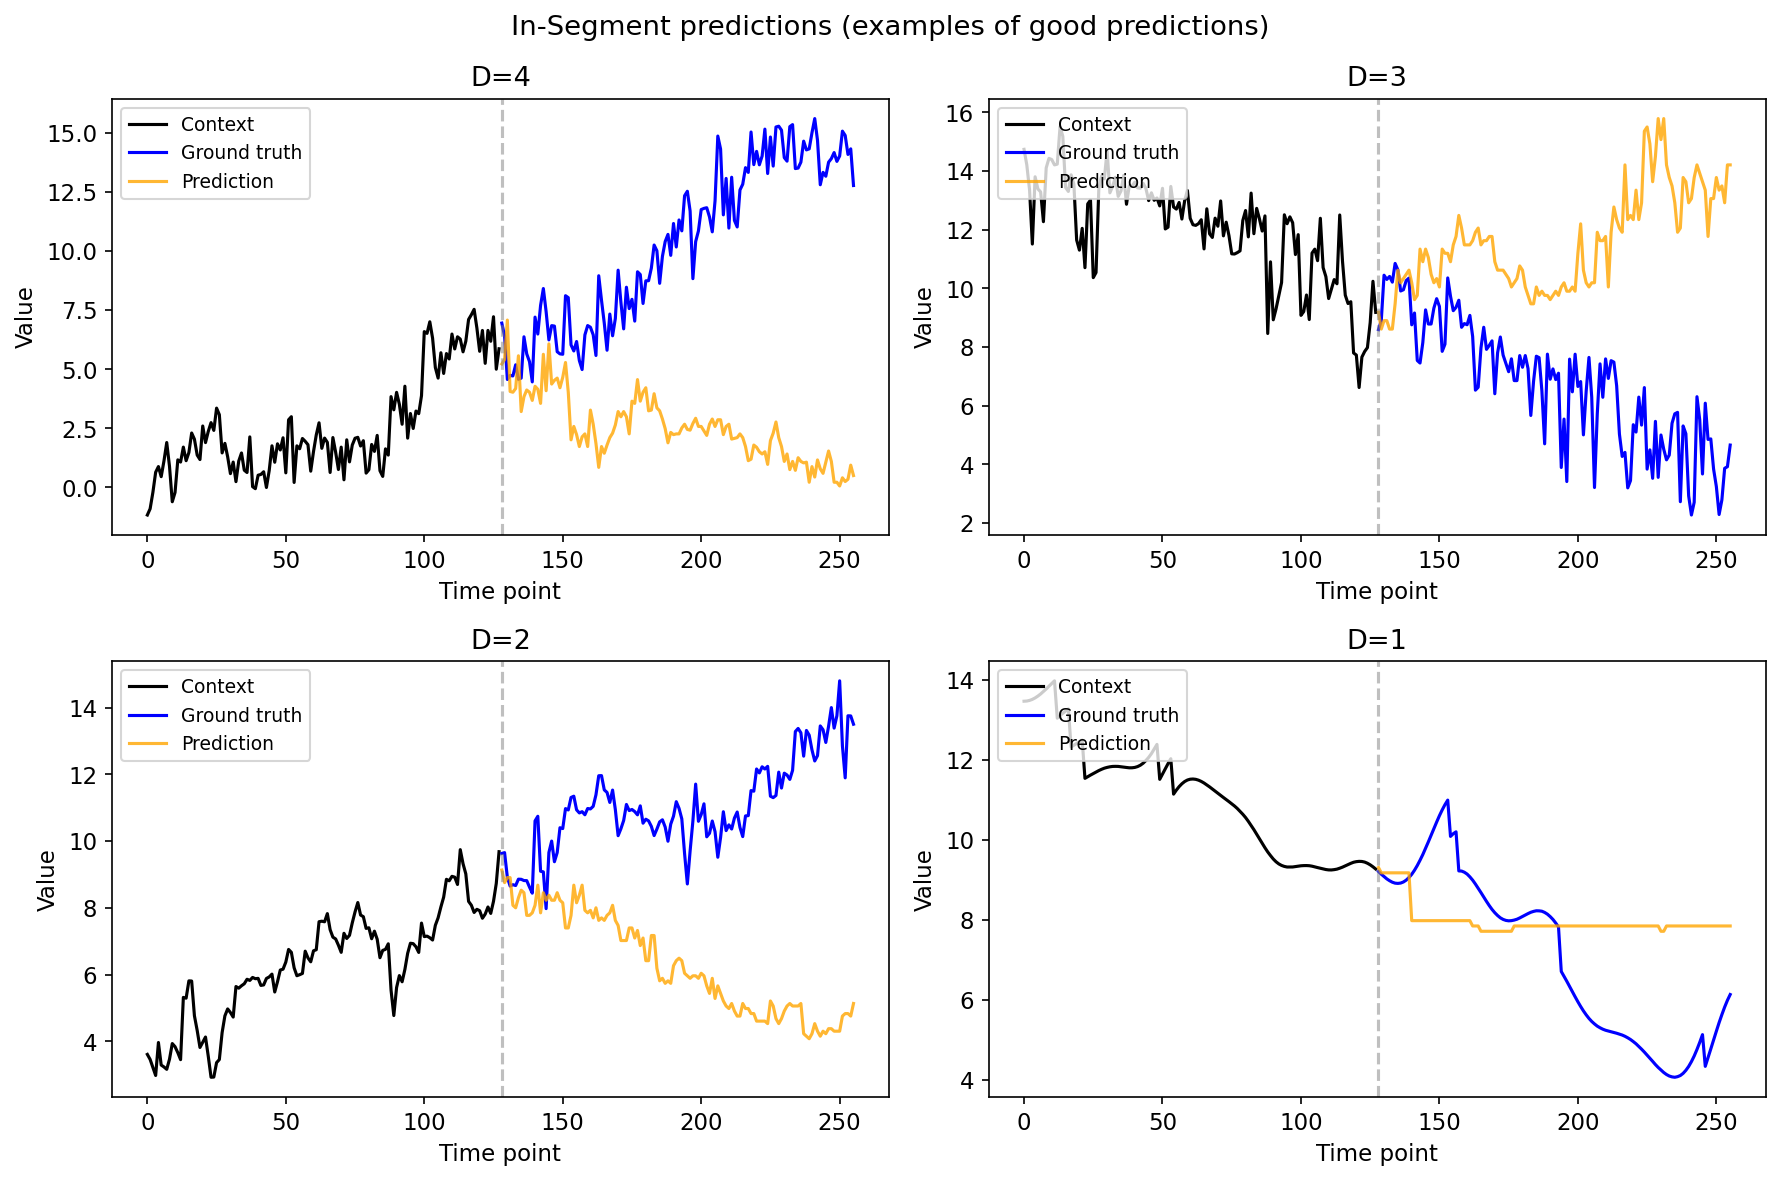

In [113]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

for row, seg_idx in enumerate(segments):
    ax = axes[row // 2, row % 2]
    j = best_signals[seg_idx]
    seg_start = (seg_idx - 1) * 256
    context = signals[j, seg_start : seg_start + 128]
    gt = signals[j, seg_start + 128 : seg_start + 256]
    pred = results[seed][f"segment{seg_idx}"][j, 128:]
    gt_cps = extract_signal_statistics(gt)["cps"]
    pred_cps = extract_signal_statistics(pred)["cps"]
    ax.plot(range(128), context, color='black', label='Context')
    ax.plot(range(128, 256), gt, color='blue', label='Ground truth')
    ax.plot(range(128, 256), pred, color='orange', alpha=0.8, label='Prediction')
    ax.axvline(128, color='gray', linestyle='--', alpha=0.5)
    ax.set_ylabel('Value')
    ax.set_xlabel('Time point')
    ax.set_title(f'D={5-seg_idx}')
    ax.legend(loc='upper left')

fig.suptitle('In-Segment predictions (examples of good predictions)')
fig.tight_layout()
plt.savefig('out/plots/in_segment_best.png', dpi=150)
plt.show()

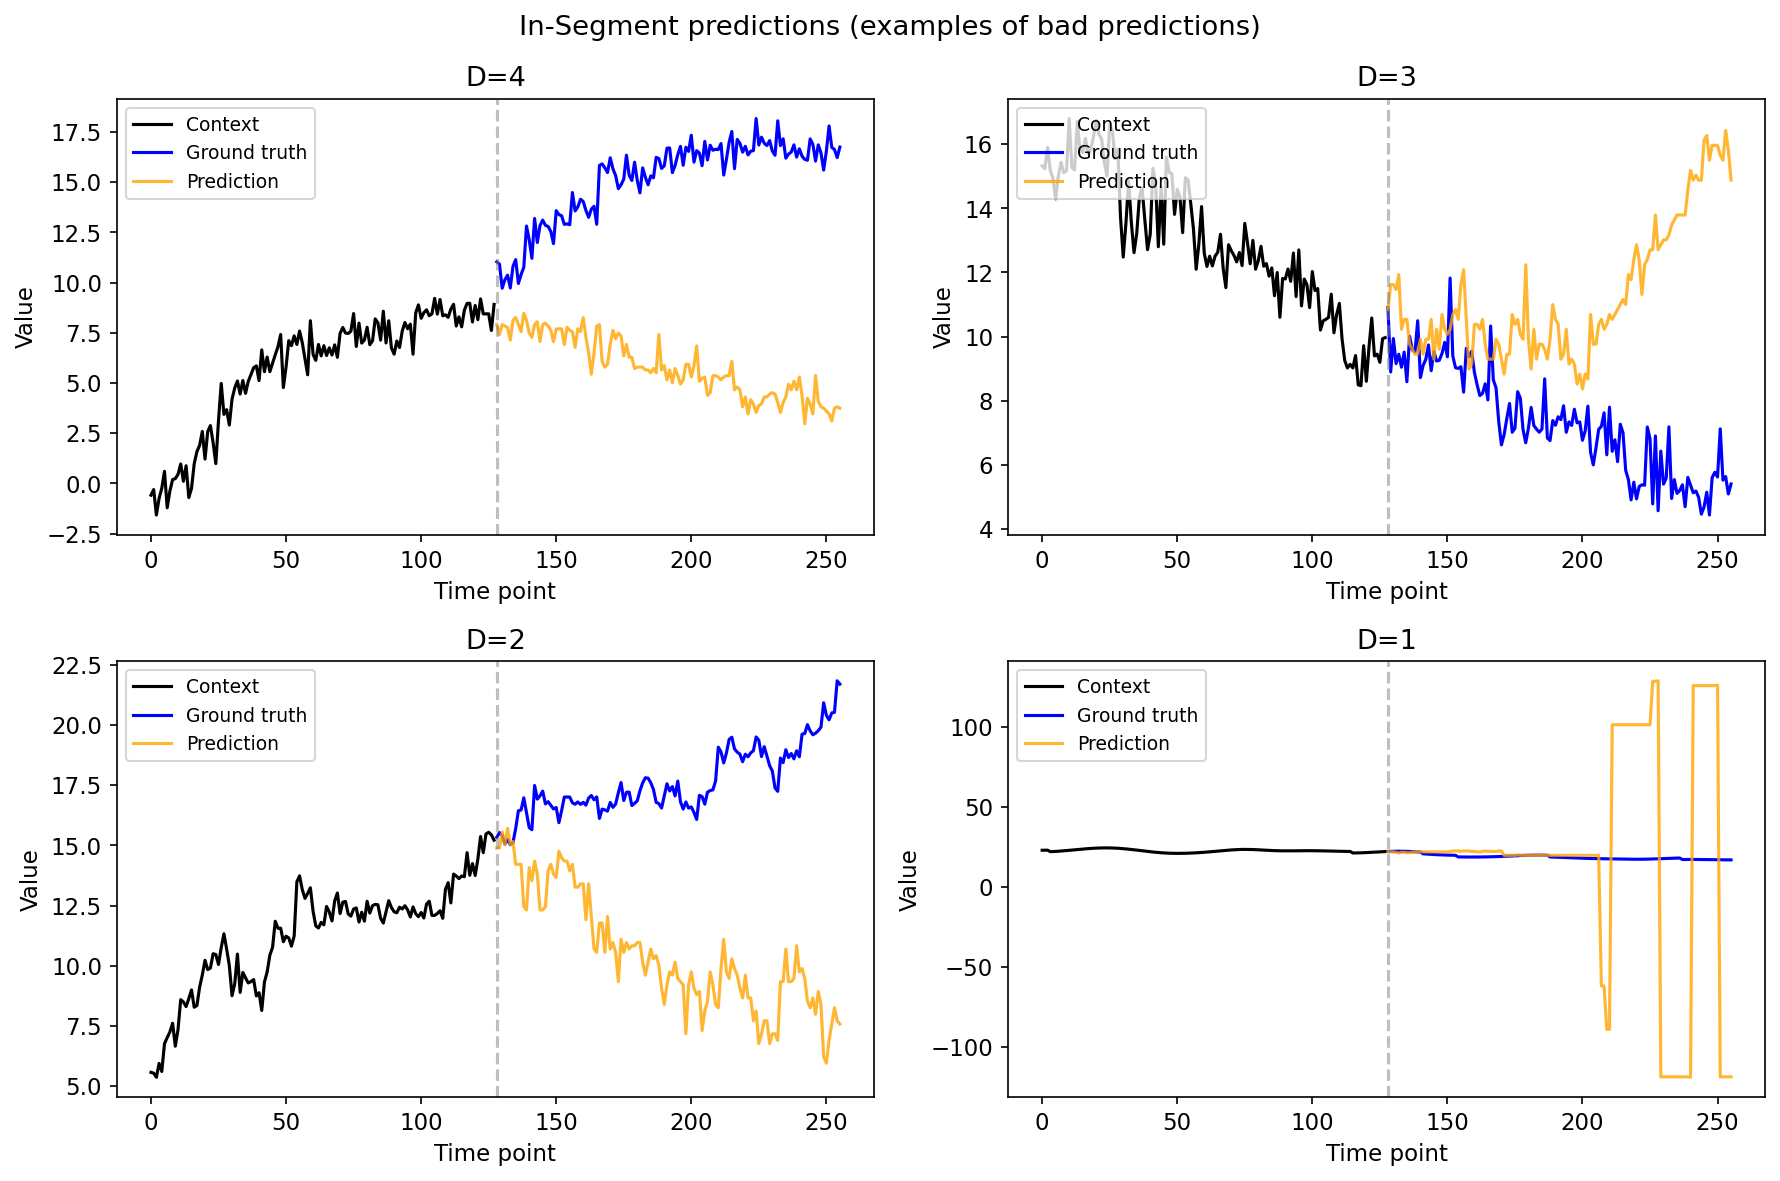

In [114]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

for row, seg_idx in enumerate(segments):
    ax = axes[row // 2, row % 2]
    j = worst_signals[seg_idx]
    seg_start = (seg_idx - 1) * 256
    context = signals[j, seg_start : seg_start + 128]
    gt = signals[j, seg_start + 128 : seg_start + 256]
    pred = results[seed][f"segment{seg_idx}"][j, 128:]
    gt_cps = extract_signal_statistics(gt)["cps"]
    pred_cps = extract_signal_statistics(pred)["cps"]
    ax.plot(range(128), context, color='black', label='Context')
    ax.plot(range(128, 256), gt, color='blue', label='Ground truth')
    ax.plot(range(128, 256), pred, color='orange', alpha=0.8, label='Prediction')
    ax.axvline(128, color='gray', linestyle='--', alpha=0.5)
    ax.set_ylabel('Value')
    ax.set_xlabel('Time point')
    ax.set_title(f'D={5-seg_idx}')
    ax.legend(loc='upper left')

fig.suptitle('In-Segment predictions (examples of bad predictions)')
fig.tight_layout()
plt.savefig('out/plots/in_segment_worst.png', dpi=150)
plt.show()

In [108]:
with open("out/predictions/cross_segment.pkl", "rb") as f:
    cross_results = pickle.load(f)

In [105]:
seed = 3040
best_cross = {}
worst_cross = {}
transitions = [(1, 2), (2, 3), (3, 4)]
for cond_seg, pred_seg in transitions:
    pred_start = (pred_seg - 1) * 256
    errors_K, errors_J, errors_V = [], [], []
    for j in range(signals.shape[0]):
        gt_signal = signals[j, pred_start : pred_start + 256]
        pred_signal = cross_results[seed][f"segment{cond_seg}"][j]
        gt_s = extract_signal_statistics(gt_signal)
        pr_s = extract_signal_statistics(pred_signal)
        err_K = abs(gt_s["num_cps"] - pr_s["num_cps"])
        if len(gt_s["jumps"]) > 0 and len(pr_s["jumps"]) > 0:
            err_J = wasserstein_distance(gt_s["jumps"], pr_s["jumps"])
        else:
            err_J = np.nan
        if len(gt_s["variances"]) > 0 and len(pr_s["variances"]) > 0:
            err_V = wasserstein_distance(gt_s["variances"], pr_s["variances"])
        else:
            err_V = np.nan
        errors_K.append(err_K)
        errors_J.append(err_J)
        errors_V.append(err_V)
    errors_K = np.array(errors_K)
    errors_J = np.array(errors_J)
    errors_V = np.array(errors_V)
    combined_error = 2 * norm(errors_K) + norm(errors_J) + norm(errors_V)
    best_cross[(cond_seg, pred_seg)] = np.nanargmin(combined_error)
    worst_cross[(cond_seg, pred_seg)] = np.nanargmax(combined_error)
    D_cond = 5 - cond_seg
    D_pred = 5 - pred_seg
    b = best_cross[(cond_seg, pred_seg)]
    w = worst_cross[(cond_seg, pred_seg)]

D=4→D=3: best=#123 (K=3, J=0.848, V=0.048)
              worst=#0 (K=42, J=8.627, V=113.989)
D=3→D=2: best=#153 (K=2, J=0.521, V=0.150)
              worst=#60 (K=37, J=9.409, V=88.560)
D=2→D=1: best=#120 (K=9, J=1.109, V=0.069)
              worst=#61 (K=37, J=11.287, V=264.389)


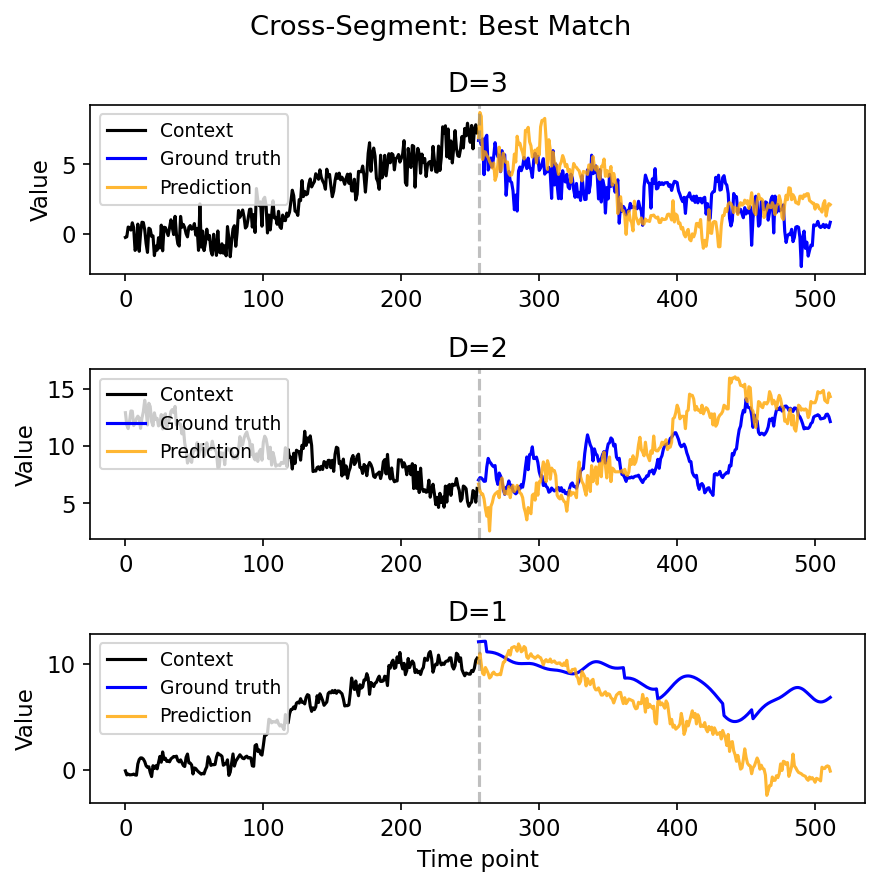

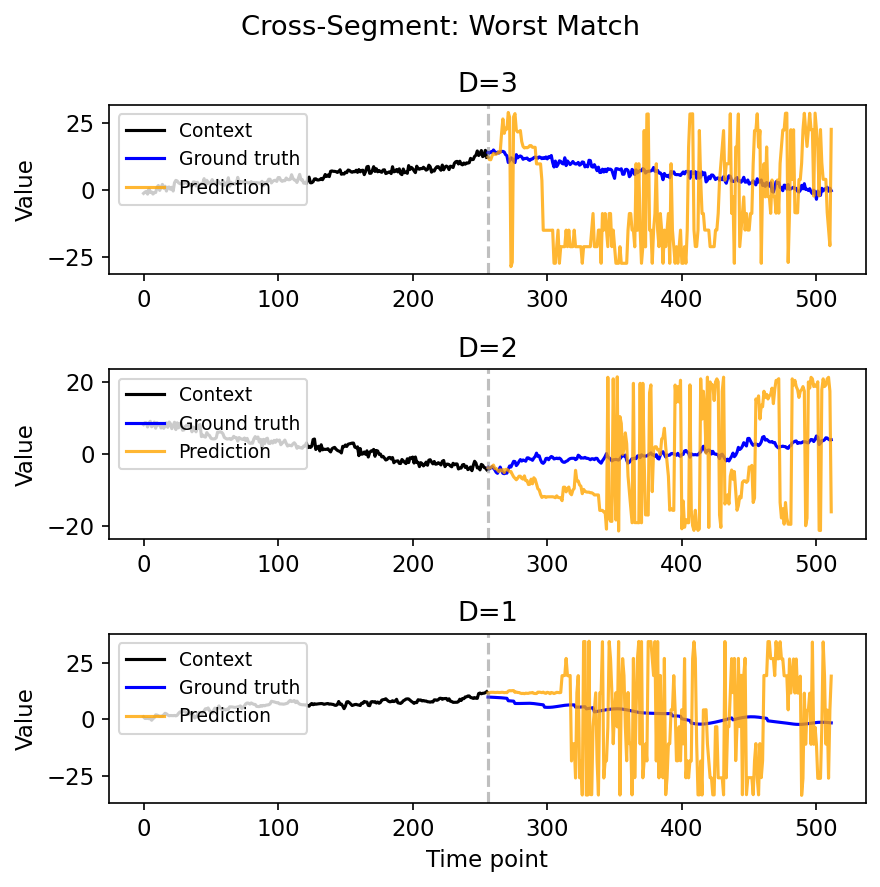

In [116]:
# Best cross-segment
fig, axes = plt.subplots(3, 1, figsize=(6, 6))

for row, (cond_seg, pred_seg) in enumerate(transitions):
    ax = axes[row]
    j = best_cross[(cond_seg, pred_seg)]
    cond_start = (cond_seg - 1) * 256
    pred_start = (pred_seg - 1) * 256
    context = signals[j, cond_start : cond_start + 256]
    gt = signals[j, pred_start : pred_start + 256]
    pred = cross_results[seed][f"segment{cond_seg}"][j][256:]
    ax.plot(range(256), context, color='black', label='Context')
    ax.plot(range(256, 512), gt, color='blue', label='Ground truth')
    ax.plot(range(256, 512), pred, color='orange', alpha=0.8, label='Prediction')
    ax.axvline(256, color='gray', linestyle='--', alpha=0.5)
    ax.set_ylabel('Value')
    ax.set_title(f'D={5-pred_seg}')
    ax.legend(loc='upper left')
axes[-1].set_xlabel('Time point')
fig.suptitle('Cross-Segment: Best Match')
fig.tight_layout()
plt.savefig('out/plots/cross_segment_best.png', dpi=150)
plt.show()

fig, axes = plt.subplots(3, 1, figsize=(6, 6))
for row, (cond_seg, pred_seg) in enumerate(transitions):
    ax = axes[row]
    j = worst_cross[(cond_seg, pred_seg)]
    cond_start = (cond_seg - 1) * 256
    pred_start = (pred_seg - 1) * 256
    context = signals[j, cond_start : cond_start + 256]
    gt = signals[j, pred_start : pred_start + 256]
    pred = cross_results[seed][f"segment{cond_seg}"][j][256:]
    ax.plot(range(256), context, color='black', label='Context')
    ax.plot(range(256, 512), gt, color='blue', label='Ground truth')
    ax.plot(range(256, 512), pred, color='orange', alpha=0.8, label='Prediction')
    ax.axvline(256, color='gray', linestyle='--', alpha=0.5)
    ax.set_ylabel('Value')
    ax.set_title(f'D={5-pred_seg}')
    ax.legend(loc='upper left')

axes[-1].set_xlabel('Time point')
fig.suptitle('Cross-Segment: Worst Match')
fig.tight_layout()
plt.savefig('out/plots/cross_segment_worst.png', dpi=150)
plt.show()